In [ ]:
import requests
import numpy as np
import pandas as pd

def fetch_flatfox_listings(limit=10000):
    url = "https://flatfox.ch/api/v1/public-listing/"
    listings = []

    while url and len(listings) < limit:
        response = requests.get(url)
        data = response.json()
        listings.extend(data['results'])

        # Pagination: proceed to next page if available
        url = data.get('next', None)

    return listings[:limit]

def extract_prices(listings):
    prices = []
    for listing in listings:
        entry = {
            'id': listing['pk'],
            'type': listing['offer_type'],
            'rent_net': listing.get('rent_net', None),
            'rent_gross': listing.get('rent_gross', None),
            'price_display': listing.get('price_display', None),
            'city': listing.get('city', None)
        }
        prices.append(entry)
    return prices

# Fetch and extract data (limiting to 10000 listings)
listings = fetch_flatfox_listings(limit=10000)
prices = extract_prices(listings)

# Convert to DataFrame for further analysis
df = pd.DataFrame(prices)
print(df.head())

In [19]:
# Save DataFrame to CSV
df.to_csv('../data/flatfox_prices.csv', index=False)

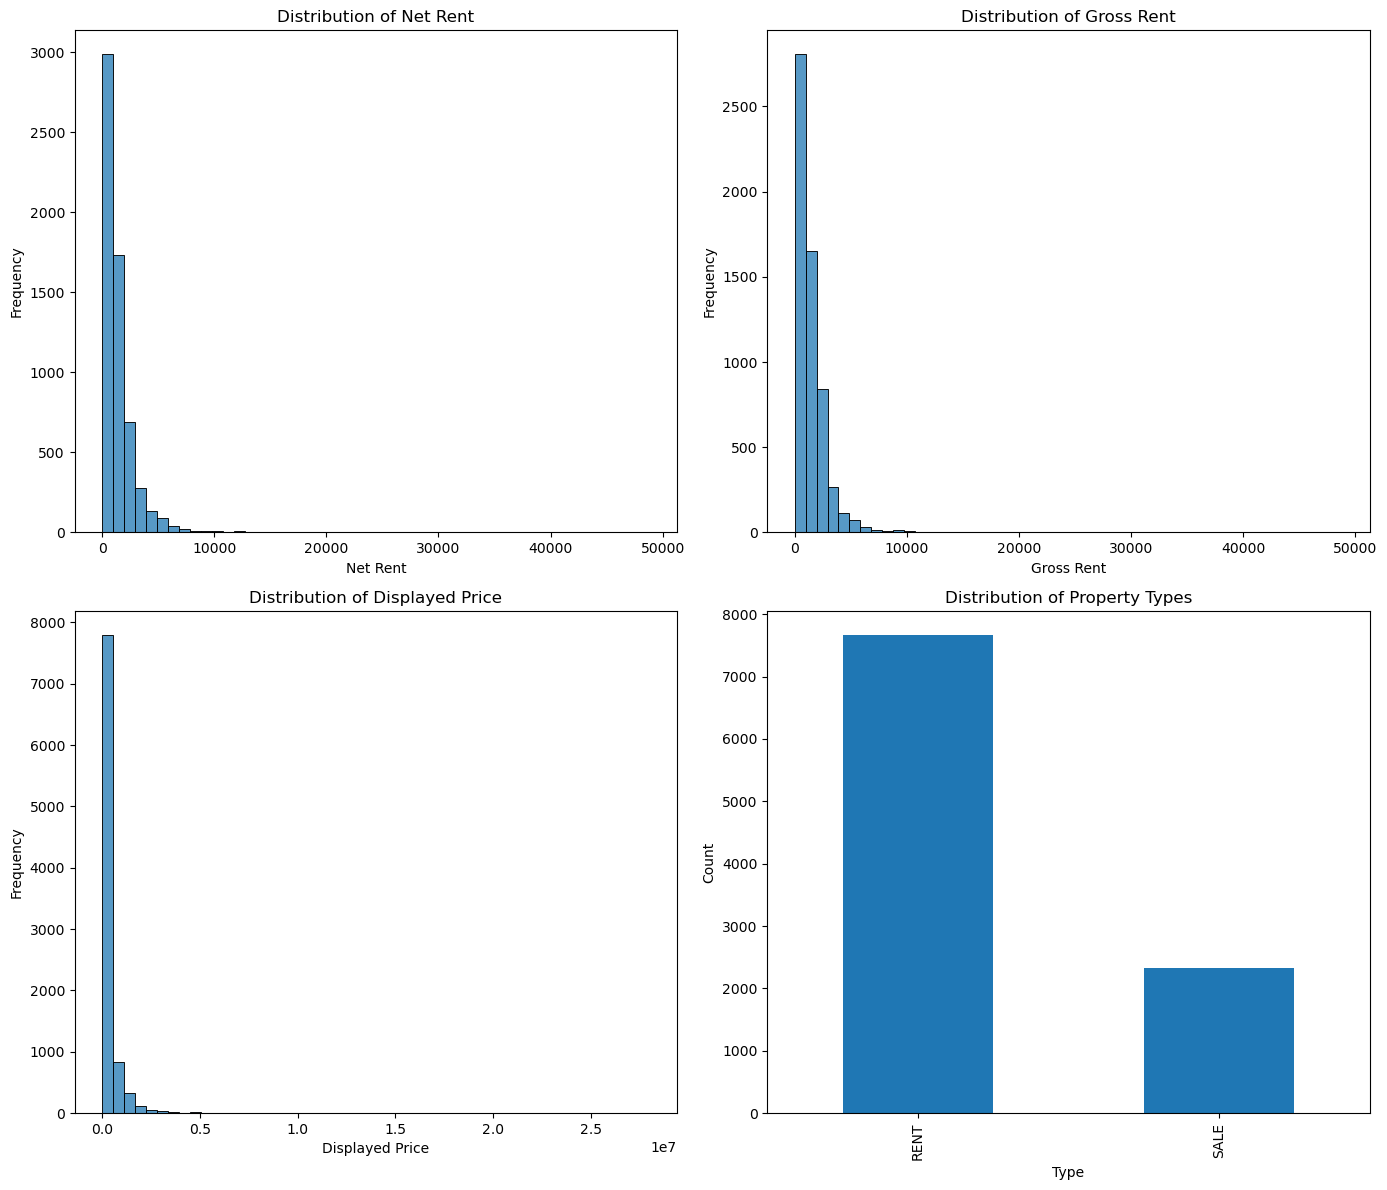

(id                      0
 type                    0
 rent_net             3959
 rent_gross           4131
 price_display         788
 city                    0
 log_rent_net         3959
 log_rent_gross       4131
 log_price_display     788
 dtype: int64,
                   id      rent_net    rent_gross  price_display  log_rent_net  \
 count   10000.000000   6041.000000   5869.000000   9.212000e+03   6041.000000   
 mean   801367.286700   1342.963251   1367.214517   2.460237e+05      6.364989   
 std    192972.163227   2004.271447   2053.547827   8.169094e+05      1.471631   
 min     26706.000000      0.000000      0.000000   1.000000e+00      0.000000   
 25%    734827.500000    150.000000    130.000000   2.000000e+02      5.017280   
 50%    858068.500000   1000.000000   1095.000000   1.670000e+03      6.908755   
 75%    943218.250000   1795.000000   1905.000000   5.292500e+03      7.493317   
 max    987469.000000  48838.000000  48838.000000   2.800000e+07     10.796284   
 
  

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values
missing_values = df.isnull().sum()

# Summary statistics for numerical columns
summary_statistics = df.describe()

# Distribution of properties by type
type_distribution = df['type'].value_counts()

# Setting up the plots
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Rent net distribution plot
sns.histplot(data=df, x='rent_net', bins=50, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Net Rent')
ax[0, 0].set_xlabel('Net Rent')
ax[0, 0].set_ylabel('Frequency')

# Rent gross distribution plot
sns.histplot(data=df, x='rent_gross', bins=50, ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Gross Rent')
ax[0, 1].set_xlabel('Gross Rent')
ax[0, 1].set_ylabel('Frequency')

# Price display distribution plot
sns.histplot(data=df, x='price_display', bins=50, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Displayed Price')
ax[1, 0].set_xlabel('Displayed Price')
ax[1, 0].set_ylabel('Frequency')

# Type distribution plot
type_distribution.plot(kind='bar', ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Property Types')
ax[1, 1].set_xlabel('Type')
ax[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

(missing_values, summary_statistics, type_distribution)


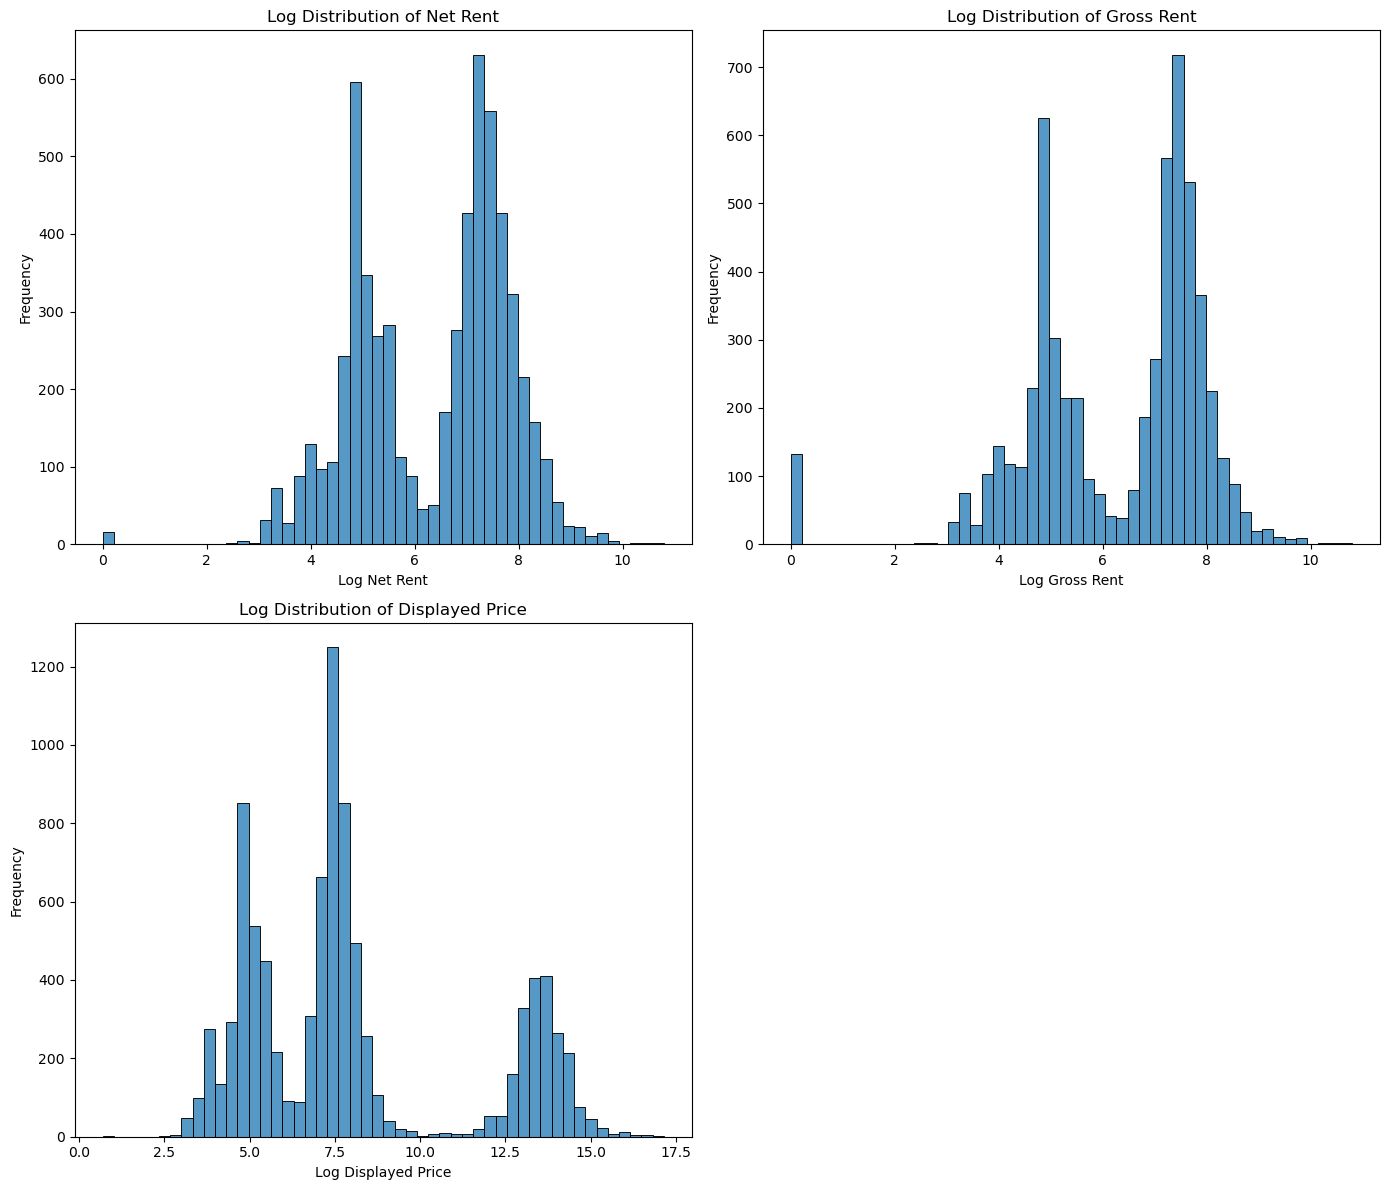

In [26]:
import numpy as np
# Logarithmic transformation of the rent and price columns, handling zero and negative values
df['log_rent_net'] = np.log(df['rent_net'] + 1)  # Adding 1 to handle zero values
df['log_rent_gross'] = np.log(df['rent_gross'] + 1)
df['log_price_display'] = np.log(df['price_display'] + 1)

# Setting up the plots with logarithmic scale
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Log Rent net distribution plot
sns.histplot(data=df, x='log_rent_net', bins=50, ax=ax[0, 0])
ax[0, 0].set_title('Log Distribution of Net Rent')
ax[0, 0].set_xlabel('Log Net Rent')
ax[0, 0].set_ylabel('Frequency')

# Log Rent gross distribution plot
sns.histplot(data=df, x='log_rent_gross', bins=50, ax=ax[0, 1])
ax[0, 1].set_title('Log Distribution of Gross Rent')
ax[0, 1].set_xlabel('Log Gross Rent')
ax[0, 1].set_ylabel('Frequency')

# Log Price display distribution plot
sns.histplot(data=df, x='log_price_display', bins=50, ax=ax[1, 0])
ax[1, 0].set_title('Log Distribution of Displayed Price')
ax[1, 0].set_xlabel('Log Displayed Price')
ax[1, 0].set_ylabel('Frequency')

# Remove empty subplot
fig.delaxes(ax[1][1])

plt.tight_layout()
plt.show()

# Proceeding to further analysis: correlation analysis and geographical distribution
# Correlation matrix
correlation_matrix = df[['rent_net', 'rent_gross', 'price_display']].corr()

# Top 5 cities with the highest average displayed price
top_cities = df.groupby('city')['price_display'].mean().sort_values(ascending=False).head(5)

In [27]:
# Filtering out listings with missing values in rent_net or price_display
filtered_data = df.dropna(subset=['rent_net', 'price_display'])

# Calculating annual rent
filtered_data['annual_rent'] = filtered_data['rent_net'] * 12

# Calculating the buy-to-rent ratio
filtered_data['buy_to_rent_ratio'] = filtered_data['price_display'] / filtered_data['annual_rent']

# Viewing the head of the dataset with the new column
filtered_data[['id', 'city', 'rent_net', 'price_display', 'annual_rent', 'buy_to_rent_ratio']].head()

/var/folders/fy/7mfyb97n7q12tbfy_b8cwnwr0000gn/T/ipykernel_30914/2242008345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['annual_rent'] = filtered_data['rent_net'] * 12
/var/folders/fy/7mfyb97n7q12tbfy_b8cwnwr0000gn/T/ipykernel_30914/2242008345.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['buy_to_rent_ratio'] = filtered_data['price_display'] / filtered_data['annual_rent']


,id,city,rent_net,price_display,annual_rent,buy_to_rent_ratio
1,33819,Lenzburg,130.0,130.0,1560.0,0.083333
2,44676,Dübendorf,1980.0,2325.0,23760.0,0.097854
5,51970,Pully,4400.0,4700.0,52800.0,0.089015
7,56908,Lausanne,2900.0,3200.0,34800.0,0.091954
8,56960,Neuchâtel,2100.0,2370.0,25200.0,0.094048


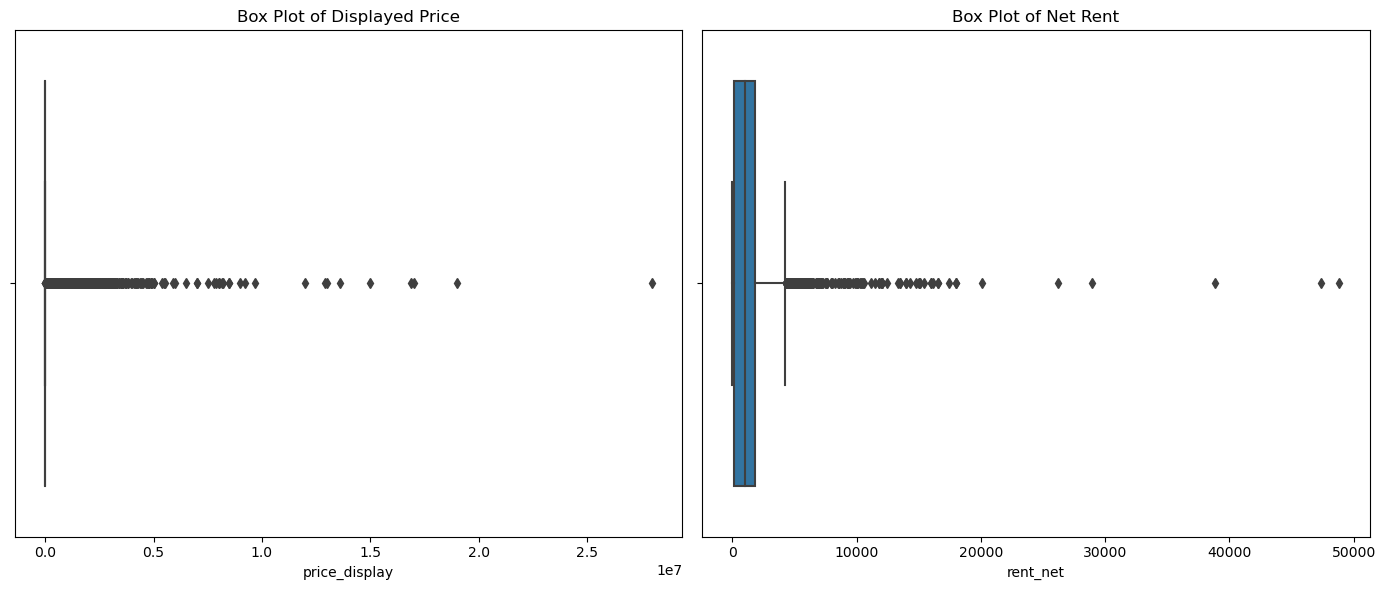

In [28]:
# Identifying outliers or inconsistencies in price_display and rent_net columns

# Descriptive statistics for price_display and rent_net
price_stats = df['price_display'].describe()
rent_stats = df['rent_net'].describe()

# Box plots to visualize potential outliers
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=df, x='price_display', ax=ax[0])
ax[0].set_title('Box Plot of Displayed Price')

sns.boxplot(data=df, x='rent_net', ax=ax[1])
ax[1].set_title('Box Plot of Net Rent')

plt.tight_layout()
plt.show()